In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

Cloning into 'BIO-NER-'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 385 (delta 8), reused 0 (delta 0), pack-reused 365
Receiving objects: 100% (385/385), 10.69 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


In [ ]:
%%capture
!pip install tensorflow==2.3

In [ ]:
%%capture
import tensorflow as tf

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
%%capture
# CRF layer for tensorflow 2 supportig keras masking
!pip install tf2crf

In [ ]:
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data

# PREPROCESSING

In [ ]:
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
from tqdm import tqdm
import random as rn

In [ ]:
# For reproducibility
seed = 937
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Original data in IOB format
file1 = "/content/drive/MyDrive/Data_Bio-NER/JNLPBA/original-data/train/Genia4ERtask1.iob2"
file2 = "/content/drive/MyDrive/Data_Bio-NER/JNLPBA/original-data/test/Genia4EReval1.iob2"

In [ ]:
input_train = read_data(file1)
input_test = read_data(file2)

Total number of sentences: 18546 
Total number of sentences: 3856 


In [ ]:
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)

In [ ]:
# First sentence of train dataset with both words and labels
print('This is what a sentence looks like:{}'.format(input_train[0]))

This is what a sentence looks like:[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')]


In [ ]:
print("\033[1m"+"Statistics for the train set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the train set:
Number of sentences: 18546
Number of tokens: 492551
Size of vocabulary: 22056
Tagset: B-RNA B-cell_line I-RNA I-protein I-DNA I-cell_type B-cell_type O I-cell_line B-DNA B-protein
Number of Tags 11


# DATA VISUALIZATION

In [ ]:
sentences_len = np.array([len(s) for s in docs_train.sentences]) #list with len for each sents

In [ ]:
#max_seq_len = np.round(sentences_len.mean()+sentences_len.std()).astype(int) #timesteps

In [ ]:
sen_mean = np.round(sentences_len.mean()).astype(int) 

In [ ]:
max_seq_len = 50 #timesteps

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


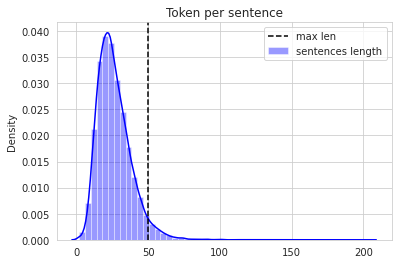

In [ ]:
sns.distplot(sentences_len, hist=True, kde=True, color="b", label="sentences length")
plt.axvline(x=max_seq_len, color="k", linestyle="--", label="max len")
plt.title("Token per sentence")
plt.legend()
plt.show()

In [ ]:
sent_less_than_msl = [s for s in docs_train.sentences if len(s) <= 50]
perc_sent = round(len(sent_less_than_msl) / len(docs_train.sentences) * 100)
print("The", perc_sent,"%", "of sentences has less or equal than 50 tokens.")

The 96 % of sentences has less or equal than 50 tokens.


# FASTTEXT PRE-TRAINED WORD VECTORS

In [ ]:
# Pre-trained word vectors trained using fastText library

import requests, zipfile, io
zip_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import codecs
print("Loading word embeddings...")

embedding_index = {}       
f = codecs.open("crawl-300d-2M.vec", encoding = "utf-8")

for line in tqdm(f):
  values = line.rstrip().rsplit(" ")
  word = values[0]
  coefs = np.asarray(values[1:], dtype ="float32")
  embedding_index[word]=coefs

f.close()  #vettori 300d per word

print("found %s word vectors" % len(embedding_index))

1079it [00:00, 10781.50it/s]

Loading word embeddings...


1999996it [03:34, 9339.78it/s]

found 1999996 word vectors


In [ ]:
len(embedding_index.get("cell")) #300 d-array

300

# PREPROCESSING FOR TRAINING

Before feeding the data to the model we need to further preprocess the text. In order to feed the data to the Bi-LSTM model, we need to ensure that all text should be of the same length. The method sequence **pad_sequences()** and variable *max_seq_len* are used for this purpose. The text which are shorter than fixed *max_seq_len* value are padded to get them to the same length, whereas text which are longer than *max_seq_len* are truncated. Then, we use the **TextVectorization** layer from tf as text encoder. This allows to transforms a sequences of strings into a list of token indices. Every token in a sequence is mapped to a corresponding integer ID. This saves a lot of memory. 

In [ ]:
# Padding sentences to the max_seq_len
from keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_train.sentences, padding="post", value="", dtype=object, truncating = "post")
X_test_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_test.sentences, padding="post", value="", dtype=object, truncating = "post")

In [ ]:
X_test_padded[812]

array(['Finally', ',', 'DR3/', 'Wsl-1', 'protein', 'expression', 'is',
       'quite', 'variable', 'among', 'these', 'NB', 'cell', 'lines', ',',
       'with', 'very', 'low', 'or', 'undetectable', 'levels', 'in', '7',
       'of', '17', 'NB', 'cell', 'lines', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype=object)

In [ ]:
# Vocabulary Key:Tag -> Value:ID_tag & Vocabulary Key:ID_tag -> Value:Tag
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
# Decoding one-hot vectors
y_train = np.argmax(y_train, axis = -1)
y_test = np.argmax(y_test, axis = -1)

In [ ]:
# Build the text encoder layer
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(split=None, standardize = None, ngrams=None,
    max_tokens=None, output_mode = "int")

In [ ]:
# Create the vocabulary
encoder.adapt(docs_train.tokens)

In [ ]:
# Extract the vocabulary
voc = np.array(encoder.get_vocabulary())

In [ ]:
# Explore first 30 more frequent words in the train set, first entry reserved for PAD
voc[:30] 

array(['', '[UNK]', 'of', 'the', '.', ',', 'and', 'in', 'to', ')', '(',
       'a', 'cells', 'that', 'by', 'with', 'is', 'expression', 'was',
       'cell', 'for', 'B', 'The', 'T', 'gene', 'human', 'activation',
       'transcription', 'protein', 'as'], dtype='<U48')

In [ ]:
# A dict mapping words to their IDs
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# A dict mapping IDs to their words
idx2word = {i: w for w, i in word_index.items()}

In [ ]:
# Map padded sentences to integer IDs
X_train = encoder(np.array(X_train_padded))
X_test = encoder(np.array(X_test_padded))

In [ ]:
# Decoding in the test set; some words that are OOV are decoded as [UNK]
for n in range(3):
  print("Original: ", docs_test.sentences[n])
  print("Round-trip: ", " ".join(voc[X_test[n]]))
  print() 

Original:  ['Number', 'of', 'glucocorticoid', 'receptors', 'in', 'lymphocytes', 'and', 'their', 'sensitivity', 'to', 'hormone', 'action', '.']
Round-trip:  [UNK] of glucocorticoid receptors in lymphocytes and their sensitivity to hormone action .                                     

Original:  ['The', 'study', 'demonstrated', 'a', 'decreased', 'level', 'of', 'glucocorticoid', 'receptors', '(', 'GR', ')', 'in', 'peripheral', 'blood', 'lymphocytes', 'from', 'hypercholesterolemic', 'subjects', ',', 'and', 'an', 'elevated', 'level', 'in', 'patients', 'with', 'acute', 'myocardial', 'infarction', '.']
Round-trip:  The study demonstrated a decreased level of glucocorticoid receptors ( GR ) in peripheral blood lymphocytes from hypercholesterolemic subjects , and an elevated level in patients with acute myocardial infarction .                   

Original:  ['In', 'the', 'lymphocytes', 'with', 'a', 'high', 'GR', 'number', ',', 'dexamethasone', 'inhibited', '[', '3H', ']', '-thymidine', 'and', 

In [ ]:
print("The word 'cell' is identified by the index: {}".format(word_index["cell"]))
print("The labels 'B-DNA'(which defines the first token of a TERM) is identified by the index: {}".format(tag2idx["B-DNA"]))

The word 'cell' is identified by the index: 19
The labels 'B-DNA'(which defines the first token of a TERM) is identified by the index: 10


# EMBEDDING MATRIX

Building the embedding matrix for the weights in the Embedding Layer. All words that aren't in the pre-trained model from fastTest would be changed to 0. 

In [ ]:
# Vocabulary size
voc_size = len(word_index)

In [ ]:
# Embedding matrix

print("preparing embedding matrix...")

words_not_found = []
nb_words = voc_size
embed_dim = 300
embedding_matrix = np.zeros((nb_words, embed_dim))


for word, i in word_index.items():
  if i >= nb_words:
    continue
  embedding_vector = embedding_index.get(word)
  if (embedding_vector is not None) and len(embedding_vector) >0:
    #words not found in the embedding index will be all zeros
    embedding_matrix[i]=embedding_vector
  else:
    words_not_found.append(word)

print("number of null word embeddings: %d" % np.sum(np.sum(embedding_matrix, axis=1)==0))
print("number of NON NULL word embeddings: %d" % np.sum(np.sum(embedding_matrix, axis=1)!=0))

preparing embedding matrix...
number of null word embeddings: 6774
number of NON NULL word embeddings: 15284


In [ ]:
print("sample words not found: {}".format(np.random.choice(words_not_found, 30)))

sample words not found: ['BCL2+' 'erythrocyte-binding' '606-611' 'Dithiocarbamates' '-90/-82'
 'perforin-expressing' 'cyclotetrapeptide' 'Ah-receptor' 'pseudo-tumor'
 '-49/-41' 'alphaIIbbeta3' 'H/C' 'OPGL' 'E2Fs'
 '1-beta-D-arabino-furanosylcytosine' '17beta-' 'tax/rex' 'E1A-positive'
 'Glucocorticosteroid' '1321-1326' 'OTF-1' 'p26rex/p24rex' '.01-.02'
 '10000-fold' 'XSCID' 'p16-negative' 'recombination-activating' 'q14'
 'conditions-concentration' 'T3-subjects']


# IMPLEMENTING MODEL ARCHITECTURE

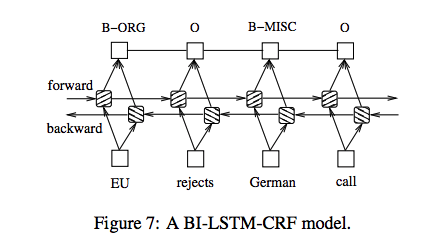


Model Architecture 

In [ ]:
# Hyperparams initialization
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING = 300

In [ ]:
# Separate about 10% of the sentences to get the validation set
X_train, X_val = X_train[:521 * BATCH_SIZE], X_train[-57 * BATCH_SIZE:]
y_train, y_val = y_train[:521 * BATCH_SIZE], y_train[-57 * BATCH_SIZE:]

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tf2crf import CRF, ModelWithCRFLoss
#from keras.layers import Masking

In [ ]:
# Model definition
#def build_model(max_seq_len, opt=None):
input = Input(shape=(max_seq_len,), dtype="int32") #timesteps
  #mask = Masking(mask_value=0)(input)
model = Embedding(input_dim=len(word_index), output_dim=EMBEDDING, weights=[embedding_matrix],
                    input_length=max_seq_len, mask_zero = True)(input) 
model = Bidirectional(LSTM(units=256, return_sequences=True,
                    recurrent_dropout=0.2))(model)
model = Bidirectional(LSTM(units=125, return_sequences=True,
                    recurrent_dropout=0.2))(model)
#dp = Dropout(0.4) (model) 
out = (Dense(len(tag2idx), activation=None))(model)
crf = CRF(dtype='float32') # CRF layer
output = crf(out)
base_model = Model(input, output)
model = ModelWithCRFLoss(base_model)

model.compile(RMSprop())

In [ ]:
"""#try different optimizers

for OPTIMAZER in [SGD(), Adam(), RMSprop()]:
  print()
  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])
  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))
  score = model.evaluate(X_test, np.array(y_test))
  print()
  print("OPTIMEZER: ", OPTIMAZER)
  print("\nTest score ", score[0])
  print("Test accuracy: ", score[1])"""

'#try different optimizers\n\nfor OPTIMAZER in [SGD(), Adam(), RMSprop()]:\n  print()\n  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])\n  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))\n  score = model.evaluate(X_test, np.array(y_test))\n  print()\n  print("OPTIMEZER: ", OPTIMAZER)\n  print("\nTest score ", score[0])\n  print("Test accuracy: ", score[1])'

# TRAINING

In [ ]:
dir_output = "/content/drive/MyDrive/BIO-NER-project/ft-bi-lstm-crf.h5"

In [ ]:
# Early stopping stops the training process when val_loss is not improving
# ModelCkpt save only the best model (model with lowest val_loss)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_crf_loss_val", patience=2, restore_best_weights=True, verbose=1)
#model_save = ModelCheckpoint(dir_output, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  real_pred = []
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

In [ ]:
%%capture
!pip3 install seqeval

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = self.model.predict(self.validation[0])[0]
        y_true, y_hat = ignoring_padding(val_predict, val_targ)
        val_f1 = f1_score(y_true, y_hat)
        
        
        self.val_f1s.append(round(val_f1, 6))
        
 
        print(f' — val_f1: {val_f1} ')

In [ ]:
# Customised callbacks
mycallbacks = [Metrics(validation=(X_val, y_val)), early_stopping]

validation shape 1824


In [ ]:
#model = build_model(max_seq_len, RMSprop())

In [ ]:
%%time
# Fit network - F1-score is measured on the validation data
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks = mycallbacks)

Epoch 1/10
521/521 [==============================] - 914s 2s/step - crf_loss: 8.0170 - accuracy: 0.8999 - val_crf_loss_val: 6.4011 - val_val_accuracy: 0.9269
Epoch 2/10
521/521 [==============================] - 912s 2s/step - crf_loss: 3.5926 - accuracy: 0.9424 - val_crf_loss_val: 4.4707 - val_val_accuracy: 0.9392
Epoch 3/10
521/521 [==============================] - 916s 2s/step - crf_loss: 2.5941 - accuracy: 0.9528 - val_crf_loss_val: 4.4516 - val_val_accuracy: 0.9391
Epoch 4/10
521/521 [==============================] - 934s 2s/step - crf_loss: 2.0047 - accuracy: 0.9599 - val_crf_loss_val: 4.0136 - val_val_accuracy: 0.9398
Epoch 5/10
521/521 [==============================] - 913s 2s/step - crf_loss: 1.5854 - accuracy: 0.9660 - val_crf_loss_val: 4.1994 - val_val_accuracy: 0.9387
Epoch 6/10
521/521 [==============================] - ETA: 0s - crf_loss: 1.2497 - accuracy: 0.9724 — val_f1: 0.7565526911875742 
Restoring model weights from the end of the best epoch.
521/521 [==========

In [ ]:
#model.summary()

In [ ]:
model.save_weights(dir_output)

**Output** = viterbi_sequence, inputs(the output of the previous
layer), sequence_lengths (mask), self.transitions (crf transmission
parameters)

# LEARNING CURVES

In [ ]:
#history.history

In [ ]:
history.epoch

[0, 1, 2, 3, 4, 5]

In [ ]:
epochs = len(history.epoch)
epochs = range(0,epochs)

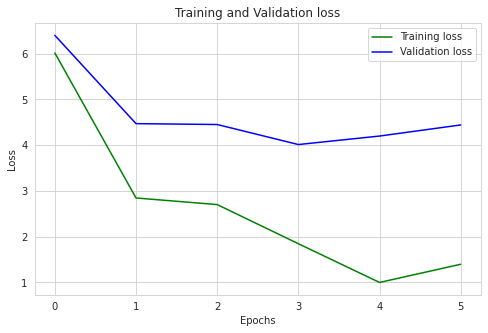

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["crf_loss"]
loss_val = history.history["val_crf_loss_val"]
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.xticks(np.arange(0, len(epochs)))
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

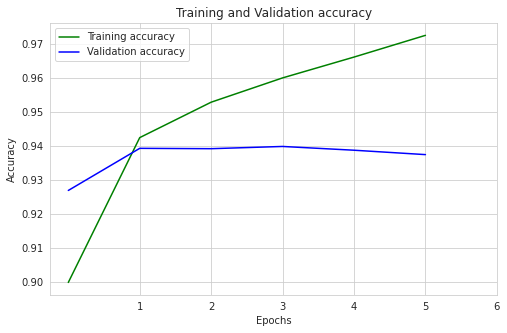

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["accuracy"]
loss_val = history.history["val_val_accuracy"]
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.xticks(np.arange(1, len(epochs)+1))
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# PREDICTION AND EVALUATION

In [ ]:
#model = build_model(max_seq_len, RMSprop())

In [ ]:
dir_output

'/content/drive/MyDrive/BIO-NER-project/ft-bi-lstm-crf.h5'

In [ ]:
#model.variables

In [ ]:
# This saves me
model.built = True 

In [ ]:
model.load_weights("/content/drive/MyDrive/BIO-NER-project/ft-bi-lstm-crf.h5")

In [ ]:
X_test = X_test[:120*BATCH_SIZE]
y_test = y_test[:120*BATCH_SIZE]

In [ ]:
%%time
y_pred = model.predict(X_test)[0]

CPU times: user 1min 17s, sys: 7.46 s, total: 1min 25s
Wall time: 44.7 s


In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

# REPORT

In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

Classification report for #1 model without LR optimization: 

              precision    recall  f1-score   support

         DNA       0.70      0.73      0.71      1047
         RNA       0.68      0.74      0.71       117
   cell_line       0.42      0.73      0.53       477
   cell_type       0.80      0.66      0.72      1889
     protein       0.67      0.78      0.72      4988

   micro avg       0.67      0.74      0.71      8518
   macro avg       0.65      0.72      0.68      8518
weighted avg       0.69      0.74      0.71      8518



In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

F1-score(relaxed): 0.709


In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

         DNA       0.70      0.73      0.71      1047
         RNA       0.68      0.74      0.71       117
   cell_line       0.42      0.73      0.53       477
   cell_type       0.80      0.66      0.72      1889
     protein       0.67      0.78      0.72      4988

   micro avg       0.67      0.74      0.71      8518
   macro avg       0.65      0.72      0.68      8518
weighted avg       0.69      0.74      0.71      8518



In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

F1-score: 0.709


# COMPARE RESULTS

In [ ]:
i = 18  #prendi il chunck di frasi da 390 a 390+32
p = model.predict(X_test[i:i+BATCH_SIZE])[0][0]
#p = np.argmax(p, axis=-1)

In [ ]:
# From tensor to array
X_true1 = tf.make_tensor_proto(X_test)
X_true1 = tf.make_ndarray(X_true1)

In [ ]:
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_true1[i], y_true[i], p):
    if w != 0:
      print("{:15}:{:15} ({})".format(idx2word[w], idx2tag[pred], true))

Word            Pred : (True)
However        :O               (O)
,              :O               (O)
there          :O               (O)
was            :O               (O)
a              :O               (O)
significantly  :O               (O)
positive       :O               (O)
association    :O               (O)
between        :O               (O)
tumor          :O               (B-protein)
beta           :O               (I-protein)
[UNK]          :B-protein       (I-protein)
expression     :O               (O)
and            :O               (O)
the            :O               (O)
degree         :O               (O)
of             :O               (O)
lymphocytic    :O               (O)
infiltration   :O               (O)
in             :O               (O)
the            :O               (O)
tumor          :O               (O)
tissue         :O               (O)
.              :O               (O)
